In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.image as mpimg
from PIL import Image

In [ ]:
# Load the model using TensorFlow's built-in method
model = tf.keras.models.load_model('D:/DATASET/Models/model_fibrosis.h5')

In [ ]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
    average_nash_score = np.mean(nash_scores)
    return int(np.round(average_nash_score, 0))

# Path to the large image
image_path = "D:/Testing (Triya ma'am)/MASSONS TRICHOME SCORING/NASH_massons trichome_40x/x2.jpg"

# Calculate average NASH score
average_nash_score = calculate_average_nash_score(image_path, model)
    
# Define the NASH score mapping
nash_scores = {
    0: "0: No fibrosis",
    1: "1: Mild/moderate perisinusoidal fibrosis",
    2: "2: Periportal/portal fibrosis",
    3: "3: Bridging fibrosis",
    4: "4: Cirrhosis"
}
    
# Get the NASH score corresponding to the maximum probability
nash_score = nash_scores[average_nash_score]
    
# Print the NASH score
print('Predicted NASH score:', nash_score)
show_image(image_path)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to apply stain separation annotation
def separate_stains(image):
    # Convert RGB image to grayscale
    gray = rgb2gray(image)
    
    # Apply Otsu's thresholding to separate stains
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    
    # Multiply original image with the blue mask
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with softmax activation for the fibrosis classification
predictions = Dense(5, activation='softmax')(x)

# Combine the base ResNet50 model with the custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [2]:
# Define ImageDataGenerator for data augmentation and loading
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and augment the images using ImageDataGenerator
train_generator = datagen.flow_from_directory(
        'D:/DATASET/CNN/fibrosis/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

model.summary()

Found 5349 images belonging to 5 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                 

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [3]:
# Fine-tune the model
model.fit(train_generator, epochs=3)

# Unfreeze some layers in the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model to apply changes
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/3
168/168 [==============================] - 4070s 24s/step - loss: 0.8510 - accuracy: 0.7349
Epoch 2/3
168/168 [==============================] - 2912s 17s/step - loss: 0.6588 - accuracy: 0.7706
Epoch 3/3
168/168 [==============================] - 2201s 13s/step - loss: 0.5906 - accuracy: 0.7865


In [4]:
# Train the model
model.fit(train_generator, epochs=10)

# Save the model using TensorFlow's built-in method
model.save('D:/DATASET/Models/model_fibrosis.h5')

Epoch 1/10
168/168 [==============================] - 2279s 13s/step - loss: 0.6169 - accuracy: 0.7833
Epoch 2/10
168/168 [==============================] - 2194s 13s/step - loss: 0.5594 - accuracy: 0.7979
Epoch 3/10
168/168 [==============================] - 2192s 13s/step - loss: 0.4738 - accuracy: 0.8301
Epoch 4/10
168/168 [==============================] - 2186s 13s/step - loss: 0.4469 - accuracy: 0.8374
Epoch 5/10
168/168 [==============================] - 2191s 13s/step - loss: 0.3711 - accuracy: 0.8680
Epoch 6/10
168/168 [==============================] - 2183s 13s/step - loss: 0.2958 - accuracy: 0.8946
Epoch 7/10
168/168 [==============================] - 2176s 13s/step - loss: 0.2288 - accuracy: 0.9205
Epoch 8/10
168/168 [==============================] - 2194s 13s/step - loss: 0.2483 - accuracy: 0.9161
Epoch 9/10
168/168 [==============================] - 2215s 13s/step - loss: 0.1725 - accuracy: 0.9454
Epoch 10/10
168/168 [==============================] - 2203s 13s/step - l

In [5]:
# Load the model using TensorFlow's built-in method
#loaded_model = tf.keras.models.load_model('D:/DATASET/Models/model_fibrosis.h5')

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [130]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
    average_nash_score = np.mean(nash_scores)
    return int(np.round(average_nash_score, 0))

# Path to the large image
image_path = "D:/Testing (Triya ma'am)/MASSONS TRICHOME SCORING/Treatment4_massons trichome_40x/xx2.jpg"

# Define the NASH score mapping
nash_scores = {
    0: "0: No fibrosis",
    1: "1: Mild/moderate perisinusoidal fibrosis",
    2: "2: Periportal/portal fibrosis",
    3: "3: Bridging fibrosis",
    4: "4: Cirrhosis"
}
    

1/1 [==============================] - 0s 141ms/step
Predicted NASH score: 2: Periportal/portal fibrosis


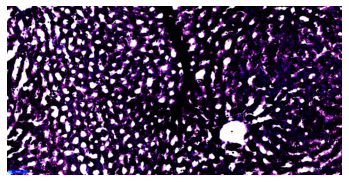

In [131]:
# Calculate average NASH score
average_nash_score = calculate_average_nash_score(image_path, model)

# Get the NASH score corresponding to the maximum probability
nash_score = nash_scores[average_nash_score]
    
# Print the NASH score
print('Predicted NASH score:', nash_score)
show_image(image_path)
